# Project: Soccer Dataset

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#other_var">Exploring Other Variables</a></li>
<li><a href="#limitations">Limitations</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

This project analyses the Soccer dataset. This database contains over 25,000 matches between 2008 to 2016 from 9 European leagues including the English Premier League, Italy Serie A, German Bundesliga and Spain Primera Liga.

For this project we will be looking at the English Premier League to try and answer the question whether possession or some other factor is important in winning matches.

<a id='wrangling'></a>
## Data Wrangling

#### Step 1
Firstly to explore the data I exported the data into Excel using SQL in SQLITE. All the useful information such as possession, shots on and off target were in XML format. I checked the integrity of the XML data in these fields by manually combing through them and spot checking the results with historical soccer data I found via Google. I found that some fields were more accurate than others. The possession field was one that was quite accurate. Only 5 rows had missing data and they all occurred in earlier seasons which I did not use.

After the initial exploration I exported the data I needed into a CSV file and read in the CSV file using Python.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
df = pd.read_csv('180813_soccer_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1140 entries, 0 to 1139
Data columns (total 14 columns):
league_name     1140 non-null object
season          1140 non-null object
stage           1140 non-null int64
match_date      1140 non-null object
home_team       1140 non-null object
away_team       1140 non-null object
home_goals      1140 non-null int64
away_goals      1140 non-null int64
home_team_id    1140 non-null int64
away_team_id    1140 non-null int64
possession      1140 non-null object
shoton          1140 non-null object
shotoff         1140 non-null object
foulcommit      1140 non-null object
dtypes: int64(5), object(9)
memory usage: 124.8+ KB


#### Step 2
The possession field is in XML format so we need to extract the data out. I did not use any Python XML library, partially because I had not thought of it, but also because I felt it was easier to just write my own code rather than learning a new package.

The data for each match has an **&lt;elapsed&gt;** tag followed by a **&lt;homepos&gt;** and **&lt;awaypos&gt;** tag. The values in these tags represent the amount of home and away possession represented as a percentage value. There are several sets of these tags which denote the amount of possession up to the elapsed time. In this case we don't need to take into account the elapsed time. We just need to identify all the homepos and awaypos values.

We do this by storing the starting index location of the **&lt;homepos&gt;** and **&lt;awaypos&gt;** tags in a list. We then iterate through the list and extract the values. 

In the below we have created a generator function which we will be used to return a list of all index positions of a tag.


In [6]:
#Generator function which yields the position of pattern p in string s
def findall(p, s):
    i = s.find(p)
    while i != -1:
        yield i
        i = s.find(p, i+1)

#### Step 3
With the function defined, we can now create our list of all starting index locations. We create two lists, one for home possession and one for away possession.

We then iterate through the list summing the home team possession total and away team possession total. We then calculate the average for home team possession (for the whole match) and average for away team possession (for the whole match). These 2 values are then stored in new columns in the dataframe. 

In [7]:
#iterate through dataframe one row at a time
for idx, row in df.iterrows():
    #poss is the cell containing the possession data we need to extract the data from
    poss = row['possession']
    
    #generate list of starting index location containing home possession data
    home_poss = [i+9 for i in findall('<homepos>', poss)]
    total_home_poss = 0
    
    #iterate through all home possession values
    for i, start_index in enumerate(home_poss):
        end_index = poss[start_index:].find('<') + start_index
        total_home_poss = total_home_poss + int(poss[start_index:end_index])
    
    #calculate average home possession and save in new column
    avg_home_poss = round(total_home_poss/(i+1),2)
    df.loc[idx,'avg_home_poss'] = avg_home_poss
    
    #generate list of starting index location containing away possession data
    away_poss = [i+9 for i in findall('<awaypos>', poss)]
    total_away_poss = 0
    
    #iterate through all away possession values
    for i, start_index in enumerate(away_poss):
        end_index = poss[start_index:].find('<') + start_index
        total_away_poss = total_away_poss + int(poss[start_index:end_index])
        
    #calculate average away possession and save in new column
    avg_away_poss = round(total_away_poss/(i+1),2)
    df.loc[idx,'avg_away_poss'] = avg_away_poss

#### Step 4
To make our analysis easier later, because score is stored in 2 columnns (home_goals and away_goals) and possession is also stored in 2 columns (avg_home_poss, avg_away_poss) we now create new columns in our dataframe to indicate whether the home or away team had more possession and whether the home or away team won, or if the match was drawn.

In [8]:
#iterate through dataframe one row at a time
for idx, row in df.iterrows():
    
    home_poss = int(row['avg_home_poss'])
    away_poss = int(row['avg_away_poss'])
    
    if home_poss >= away_poss:
        s = 'h' #home team had more possession
    else:
        s = 'a' #away team had more possession
    
    #store result in new column. idx is the row index so we are populating one row at a time
    df.loc[idx,'home_or_away_poss'] = s
    
    home_goals = int(row['home_goals'])
    away_goals = int(row['away_goals'])
    
    if home_goals > away_goals:
        s = 'h' #home team won
    elif home_goals < away_goals:
        s = 'a' #away team won
    else:
        s = 'd' #match was drawn
        
    #store result in new column. idx is the row index so we are populating one row at a time
    df.loc[idx,'home_or_away_win'] = s

#### Step 5

We now create a new dataframe which will only contain the data needed to plot our graph. This new dataframe will contain the following data and will be categorised by team and by season.
* Team
* Season
* Total number of matches won
* Total number of matches where the team had majority of possession

The first part is to create a temporary dataframe to group the team by season and summing the total number of matches won.

In [9]:
#Two dataframes grouped by team, season and number of wins. One for home, one for away.
df_tmp1a = df.query('home_or_away_win == "h"').groupby(['home_team','season']).size().reset_index(name = 'won')
df_tmp1b = df.query('home_or_away_win == "a"').groupby(['away_team','season']).size().reset_index(name = 'won')

#Make sure columns are same so we can concatenate
df_tmp1a.rename(columns={'home_team':'team'}, inplace=True)
df_tmp1b.rename(columns={'away_team':'team'}, inplace=True)

#Concatenate the two dataframes, summing the home and away wins
df_tmp1 = pd.concat([df_tmp1a,df_tmp1b]).groupby(['team','season']).won.sum().reset_index(name = 'total_matches_won')

We do the same to calculate the total number of matches where the team had more possession.

In [10]:
#Two dataframes grouped by team, season and matches with more possession. One for home, one for away.
df_tmp2a = df.query('home_or_away_poss == "h"').groupby(['home_team','season']).size().reset_index(name = 'poss')
df_tmp2b = df.query('home_or_away_poss == "a"').groupby(['away_team','season']).size().reset_index(name = 'poss')

#make sure columns are same so we can concatenate
df_tmp2a.rename(columns={'home_team':'team'}, inplace=True)
df_tmp2b.rename(columns={'away_team':'team'}, inplace=True)

#Concatenate the two dataframes, summing the home and away possession
df_tmp2 = pd.concat([df_tmp2a,df_tmp2b]).groupby(['team','season']).poss.sum().reset_index(name = 'total_matches_more_poss')

Finally we merge the two temporary dataframes and form our final table

In [11]:
df_poss = pd.merge(df_tmp1,df_tmp2)
df_poss.head()

,team,season,total_matches_won,total_matches_more_poss
0,Arsenal,2013/2014,24,30
1,Arsenal,2014/2015,22,26
2,Arsenal,2015/2016,20,29
3,Aston Villa,2013/2014,10,11
4,Aston Villa,2014/2015,10,22


<a id='eda'></a>
## Exploratory Data Analysis

#### Question: Does possession really matter in winning matches?
We are now ready to perform exploratory data analysis to try and answer this question. We start by plotting our results in a horizonatal bar graph. Three graphs are plotted one for each season. The graph shows the total number of matches won and the total number of matches where the team had more possession.

General observation - we can see that the most successful teams like Liverpool, Manchester United, Manchester City, Chelsea, Tottenham and Arsenal are always at or near the top with most possession. This makes sense as they have the best players and it is natural that they will see more of the ball during a match. But does this translate to won matches? This is not entirely clear. Looking at the blue bars (number of matches won) one would have expected it to also start from more to less when looking at the graph from top to bottom but this is not always the case.

For example, here are some anomolies:

In season 2013/2014, Southampton, a mid-tier team finished the season at the top of the possession table. In almost half of these matches where they dominated possession they actually didn't win the match (either drew or lost).

Likewise Swansea, despite being a low to mid tier team finished quite high in the possession table for all 3 seasons. Their manager Brendan Rogers was famed for his teams playing beautiful football based on possession (he was eventually recruited by Liverpool for some of these reasons) but that didn't necessarily translate to won matches.

In season 2015/2016, Leicester who at the beginning of the season, were odds at 5000-1 to win, surprisingly did manage to win the league. Their possession stats was actually third worst during that campaign but they managed to win the most number of matches.

We can also see, that between the 3 seasons, the latest season 2015/2016 saw possession matter least in the ability for a team to win matches (the blue bars are more even than the other seasons). In order to see if this is perhaps a trend more data from other seasons will need to be further analysed.


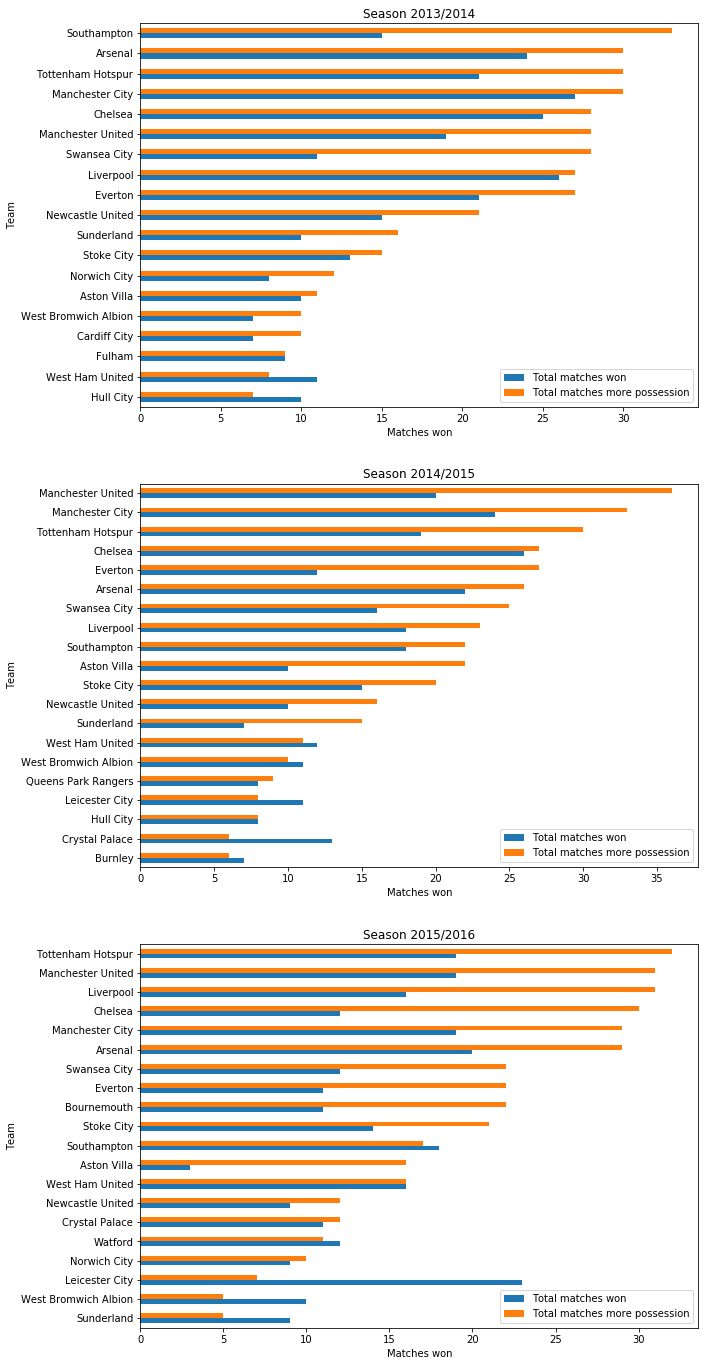

In [12]:
#Create 3 subplots
fig, axes=plt.subplots(3, figsize=(10,24))
df_poss.query('season=="2013/2014"').sort_values(by=['total_matches_more_poss'],ascending=True).plot(ax=axes[0], kind='barh', x='team', title='Season 2013/2014')
df_poss.query('season=="2014/2015"').sort_values(by=['total_matches_more_poss'],ascending=True).plot(ax=axes[1], kind='barh', x='team', title='Season 2014/2015')
df_poss.query('season=="2015/2016"').sort_values(by=['total_matches_more_poss'],ascending=True).plot(ax=axes[2], kind='barh', x='team', title='Season 2015/2016')

#Rename the legend, x label and y label for all 3 plots
for i in range(0,3):
    axes[i].set_xlabel('Matches won')
    axes[i].set_ylabel('Team')
    axes[i].legend(['Total matches won','Total matches more possession'])


<a id='other_var'></a>
## Exploratoring Other Variables
#### More Data Wrangling
We now turn to other factors to see what sort of influence they have on teams winning matches. Maybe Leicester excelled at other areas to enable them to surprisingly win in 2015/2016.

We will now explore the number of shots taken during a match - namely shots on target, shots off target and shots blocked. As before the original data is in XML format and we will need to extract out the information.

First we extract the number of shots taken but was off target, for the home team and the away team. This is fairly straight-forward as we just find all **&lt;team&gt;** occurrences in the cell, check whether the team is the home team or away team and create counters. We then store the result in 2 new columns in our dataframe.

In [13]:
#iterate through dataframe one row at a time
for idx, row in df.iterrows():
    shotoff = row['shotoff']
    
    #find start location in string of tag
    shotoff_list = [i+6 for i in findall('<team>', shotoff)]
    
    home_shotoff = 0
    away_shotoff = 0
    #iterate through list
    for i, start_index in enumerate(shotoff_list):
        end_index = shotoff[start_index:].find('<') + start_index
        team = int(shotoff[start_index:end_index])
        if team == int(row['home_team_id']):
            home_shotoff += 1
        else:
            away_shotoff += 1
    
    #store result in new columns. idx is the row index so we are populating one row at a time
    df.loc[idx,'home_shotoff'] = home_shotoff
    df.loc[idx,'away_shotoff'] = away_shotoff

We do the same for shots on target and blocked shots. This one is slightly more complicated because both blocked shots and shots on target data are in the same cell. We just need to look for the preceding **&lt;blocked&gt;** tag or **&lt;shoton&gt;** tag. Note that I actually used **&lt;blocked&gt;1** and **&lt;shoton&gt;1** as there were other **&lt;shoton&gt;** tags that were unrelated.

We then do the same as the previous dataframe - sum the total and save home_blocked, away_blocked, home_shoton, away_shoton into their own columns in the dataframe.

In [14]:
#iterate through dataframe one row at a time
for idx, row in df.iterrows():
    shoton = row['shoton']
    
    #find start location in string of tag blocked
    shoton_blocked = [i for i in findall('<blocked>1', shoton)]   
    home_blocked = 0
    away_blocked = 0
    
    #iterate through list
    for i, start_index in enumerate(shoton_blocked):
        
        #get the team id which follows the initial tag
        next_index = shoton[start_index:].find('<team>')
        #There was one data issue where no team tag was found. In this case just ignore and move on to the next item on the list
        if next_index == -1:
            continue
        #this gives the start index location of the team id
        team_index_start = next_index + 6 + start_index
        
        #this gives the end index location of the team id
        team_index_end = shoton[team_index_start:].find('<') + team_index_start
        team = int(shoton[team_index_start:team_index_end])
        
        if team == int(row['home_team_id']):
            home_blocked += 1
        else:
            away_blocked += 1
    
    #find start location in string of tag shoton
    shoton_shoton = [i for i in findall('<shoton>1', shoton)]            
    home_shoton = 0
    away_shoton = 0 
    
    #iterate through list
    for i, start_index in enumerate(shoton_shoton):
        
        #get the team id which follows the initial tag
        next_index = shoton[start_index:].find('<team>')
        #There was one data issue where no team tag was found. In this case just ignore and move on to the next item on the list
        if next_index == -1:
            continue
        #this gives the start index location of the team id        
        team_index_start = next_index + 6 + start_index
        
        #this gives the end index location of the team id
        team_index_end = shoton[team_index_start:].find('<') + team_index_start
        team = int(shoton[team_index_start:team_index_end])
        
        if team == int(row['home_team_id']):
            home_shoton += 1
        else:
            away_shoton += 1    
    
    #store result in new columns. idx is the row index so we are populating one row at a time
    df.loc[idx,'home_blocked'] = home_blocked
    df.loc[idx,'away_blocked'] = away_blocked
    df.loc[idx,'home_shoton'] = home_shoton
    df.loc[idx,'away_shoton'] = away_shoton

Now we create a new dataframe with only the data we need for plotting. This new dataframe will contain the following data.
* Team
* Total shots on target
* Total shots off target
* Total shots blocked

In [15]:
#This sums up the total number of shots on target, off-target and blocked for each home team in the season
df_tmp3a = df.query('season=="2015/2016"').groupby('home_team')['home_shoton','home_shotoff','home_blocked']\
    .apply(lambda x : x.astype(int).sum()).reset_index()
#This sums up the total number of shots on target, off-target and blocked for each away team in the season    
df_tmp3b = df.query('season=="2015/2016"').groupby('away_team')['away_shoton','away_shotoff','away_blocked']\
    .apply(lambda x : x.astype(int).sum()).reset_index()

#Rename columns so both dataframes are the same
df_tmp3a.rename(columns={'home_team':'team','home_shoton':'shoton','home_shotoff':'shotoff','home_blocked':'blocked'}, inplace=True)
df_tmp3b.rename(columns={'away_team':'team','away_shoton':'shoton','away_shotoff':'shotoff','away_blocked':'blocked'}, inplace=True)

#Concatenate both dataframes, summing the total for each shoton, shotoff and blocked
df_shot = pd.concat([df_tmp3a,df_tmp3b], ignore_index=True).groupby(['team'])['shoton','shotoff','blocked'].apply(lambda x : x.astype(int).sum()).reset_index()
df_shot.head()

,team,shoton,shotoff,blocked
0,Arsenal,151,224,117
1,Aston Villa,91,177,77
2,Bournemouth,107,194,109
3,Chelsea,131,226,130
4,Crystal Palace,119,191,96


#### Analysis
We now produce three plots. The first plot shows all shots at goal for each team, that were on target, off target or blocked. The next two plots, using the previous dataframe, shows how many matches each team won during the season and how many matches they had more possession in order to give some context.

The champions Leicester were in position 8 with the total number of shots at goal - nothing remarkable. The teams in position 7 and 9 to either side of Leicester, finished 6 and 13 respectively in the number of matches won. So given that Leicester did not have that much possession either, it must have been other factors that contributed to them winning so many matches. Or perhaps it was just a fluke - a longshot as their opening 5000-1 odds suggest.

The next 3 teams with most won matches, Arsenal, Manchester City and Manchester United, finished quite high in the possession stats. All also finished quite high in the shots stats except for Manchester United who finished 14th. Manchester United however finished 2nd in the possession stats.

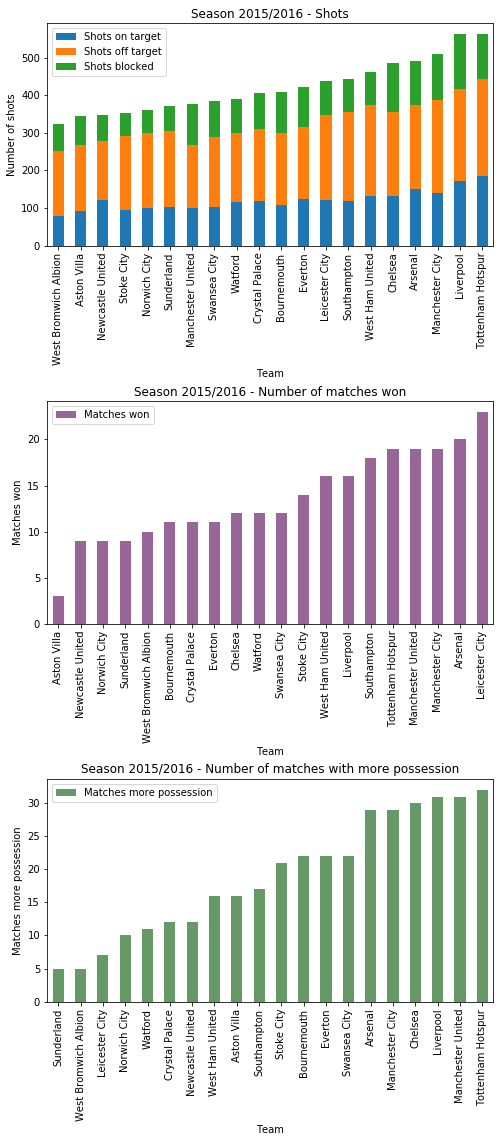

In [21]:
#Create 3 subplots
fig, axes=plt.subplots(3, figsize=(8,18))
#Adjust the whitespace between the subplots so the x labels are not cut-off
plt.subplots_adjust(hspace=0.7)

#To sort on 3 separate columns create a temporary _t summing the 3 columns
df_plot = df_shot.assign(_t=df_shot.iloc[:,1:].sum(axis=1)).sort_values(by='_t',ascending=True).drop('_t',1)\
    .plot(ax=axes[0], kind='bar', x='team', stacked=True, title='Season 2015/2016 - Shots')
axes[0].set_xlabel('Team')
axes[0].set_ylabel('Number of shots')
axes[0].legend(['Shots on target','Shots off target','Shots blocked'])

df_poss.query('season=="2015/2016"')[['team','total_matches_won']].sort_values(by=['total_matches_won'],ascending=True)\
    .plot(ax=axes[1], kind='bar', x='team', color='#996699', title='Season 2015/2016 - Number of matches won')
axes[1].set_xlabel('Team')
axes[1].set_ylabel('Matches won')
axes[1].legend(['Matches won'])

df_poss.query('season=="2015/2016"')[['team','total_matches_more_poss']].sort_values(by=['total_matches_more_poss'],ascending=True)\
    .plot(ax=axes[2], kind='bar', x='team', color='#669966',  title='Season 2015/2016 - Number of matches with more possession')
axes[2].set_xlabel('Team')
axes[2].set_ylabel('Matches more possession')
axes[2].legend(['Matches more possession'])


<a id='limitations'></a>
## Limitations
All the interesting data in this dataset such as goals, possession, shoton and shotoff were stored as XML. So the initial challenge was how to extract the data that I needed. In order to do this I had to study the structure of the XML to make sure I obtained the data from the right tags. I didn't use any Python XML library to do this but instead wrote my own code to extract the data. This was challenging but I was able to get it done. I felt writing my own code somewhat easier than learning a library that I was unfamiliar with.

The next problem was around data integrity. I initially wanted to use the goal data, that is at what minute of the match was a goal scored. After extracting the data I realised that there was a surprisingly large number of inaccuracies. For example if the score was 2-1, the XML data showed that 4 goals were scored instead of 3. I exported the data into Excel and performed lookups with the actual result to identify these anomalies. In the end I decided not to use the goal data and instead used the shoton, shotoff and possession data for my analysis as these were in better shape. The possession data had some empty data from earlier seasons but the later seasons that I ended up using did not have any empty data. I checked its integrity by spot checking my results with websites such as Sky Sports Football to verify. Because I only spot checked a few, it is possible that there could be inaccuracies that I would have missed, but I felt a small margin of error would be acceptable.

For the Python code I took it one step at a time and found it helpful to break the code down into smaller pieces. I experimented by using the Python command line. Alot of useful advise was found in the Stack Overflow website.

Another challenge I had was in the direction of the analysis. I wasn't really sure where I was going when I started my analysis. Indeed the eventual path was forged one step at a time rather than an overview plan that I knew beforehand.



<a id='conclusions'></a>
## Conclusions

Having more possession do generally mean that you are more likely to win a match but over the 3 seasons it seems this is mattering less and less - in particular season 2015/2016. To see if this is perhaps a trend we would need to analyse data over a greater number seasons.

There are also a number of anomolies. Those having alot of possession (Swansea in all 3 seasons) but not winning that many matches and those not having alot of possession (Leicester in season 2015/2016) but winning alot of matches. Both these cases suggests possession, while being influental, is perhaps not the most important factor in a team's ability to win a match.

We further analysed the number of shots each team made over the season to see if this could be another factor. The results for this analysis proved inconclusive as results were generally as expected (with one or two surprises such as Manchester United, a successful team, having fewer number of shots).